# Home Credit Default Risk

1. Introdução | Overview
2. Descrição dos dados | Data Description
3. Carregando os dados | Load data
4. Análise Exploratória | Data Exploration 

    4.1 Empréstimos - dados de treinamento | Loan - train data set
        4.1.1 Distribuição da variavel Target | Target Distribuction 
        4.1.2 Analise dos empréstimos | Loan analysis
    4.2 Analise do histórico de crédito | Todo 
        4.2.1 Crédito anteriores fornecidos por outras instituições | Todo 
        4.2.2 Crédito anteriores na Credit Bureau | Todo 
        4.2.3 Histórico mensal de emprestimo na Home Credit | Todo 
        4.2.4 Histórico mensal no cartão de crédito na Home Credit | Todo 
        4.2.5 Solicitações de crédito anteriores na Home Credit | Todo 
        4.2.6 Histórico de amortização na Home Credit | Todo 
    4.3 Todo
5. Correlação | Correlation
6. Feature Selection with Random Forest
7. ...

## 1. Introdução | Overview

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

[Home Credit Group](http://www.homecredit.net/) strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.


## 2. Descrição dos Dados | Data Description


* application_{train|test}.csv

    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.

* bureau.csv

    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

* bureau_balance.csv

    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

* POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.
installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

![teste](home_credit.png)

** Pacotes | Import packages **

In [52]:
import time
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

# DataViz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

%matplotlib inline
plt.style.use('ggplot')
# sns.set_style('whitegrid')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### 3. Carregando os dados | Load Data

In [2]:
def load_data(data_src):
    
    start_time = time.time()
    
    train = pd.read_csv('{}application_train.csv'.format(data_src))
    test = pd.read_csv('{}application_test.csv'.format(data_src))
    print('Train and test tables loaded.')
    
    bureau = pd.read_csv('{}bureau.csv'.format(data_src))
    bureau_bal = pd.read_csv('{}bureau_balance.csv'.format(data_src))
    print('Bureau data loaded.')
    
    prev = pd.read_csv('{}previous_application.csv'.format(data_src))
    print('Previous applications data loaded.')
    
    cred_card_bal = pd.read_csv('{}credit_card_balance.csv'.format(data_src))
    print('Credit card balance loaded.')
    
    pos_cash_bal = pd.read_csv('{}POS_CASH_balance.csv'.format(data_src))
    print('POS cash balance loaded.')
    
    ins = pd.read_csv('{}installments_payments.csv'.format(data_src))
    print('Installments data loaded.')
    
    # error if using engine c - 'utf-8' codec can't decode byte 0x85
    data_description = pd.read_csv('{}HomeCredit_columns_description.csv'.format(data_src), engine='python')
    
    print('Time it took to load all the data: {:.4f}s\n'.format(time.time() - start_time))
    
    return train, test, bureau, bureau_bal, prev, cred_card_bal, pos_cash_bal, ins, data_description

train, test, bureau, bureau_bal, prev, cred_card_bal, pos_cash_bal, ins, data_description = load_data('data/all/')

Train and test tables loaded.
Bureau data loaded.
Previous applications data loaded.
Credit card balance loaded.
POS cash balance loaded.
Installments data loaded.
Time it took to load all the data: 63.4767s



## 4. Analise Exploratória | Data Exploration

**Table Description**

In [ ]:
train_desc =  data_description[data_description['Table'] == 'application_{train|test}.csv']
train_desc[['Row', 'Description', 'Special']].head(10)

In [ ]:
# Column detail
def print_col_description(col_name):
    return(train_desc[train_desc['Row'] == col_name]['Description'].values)

print('NAME_CONTRACT_TYPE: {}'.format(print_col_description('NAME_CONTRACT_TYPE')))
print('TARGET: {}'.format(print_col_description('TARGET')))

In [ ]:
train.headad()

### Missing values

In [22]:
def missing_data(data):
    total = data.isnull().count()
    missing = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    return pd.concat([total, missing, percent], axis=1, 
                     keys=['Total', 'Missing', 'Percent']) \
                     .sort_values(by=['Percent'], ascending=False)

In [23]:
# train dataset
missing_data(train).head(10)

,Total,Missing,Percent
COMMONAREA_MEDI,307511,214865,69.872297
COMMONAREA_AVG,307511,214865,69.872297
COMMONAREA_MODE,307511,214865,69.872297
NONLIVINGAPARTMENTS_MODE,307511,213514,69.432963
NONLIVINGAPARTMENTS_AVG,307511,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,307511,213514,69.432963
FONDKAPREMONT_MODE,307511,210295,68.386172
LIVINGAPARTMENTS_MODE,307511,210199,68.354953
LIVINGAPARTMENTS_AVG,307511,210199,68.354953
LIVINGAPARTMENTS_MEDI,307511,210199,68.354953


In [24]:
# test dataset
missing_data(test).head(10)

,Total,Missing,Percent
COMMONAREA_AVG,48744,33495,68.716150
COMMONAREA_MODE,48744,33495,68.716150
COMMONAREA_MEDI,48744,33495,68.716150
NONLIVINGAPARTMENTS_AVG,48744,33347,68.412523
NONLIVINGAPARTMENTS_MODE,48744,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,48744,33347,68.412523
FONDKAPREMONT_MODE,48744,32797,67.284179
LIVINGAPARTMENTS_AVG,48744,32780,67.249302
LIVINGAPARTMENTS_MODE,48744,32780,67.249302
LIVINGAPARTMENTS_MEDI,48744,32780,67.249302


### Distribuição da variável Target | Target Distribuction

In [35]:
# Grafico com Plotly - Vou utilizar o seaborn como principal dataviz

def graphic_target_distribution():
    trace0 = go.Bar(
                x = train[train["TARGET"]== 0]["TARGET"].value_counts().index.values,
                y = train[train["TARGET"]== 0]["TARGET"].value_counts().values,
                name='Good credit'
        )

    trace1 = go.Bar(
                x = train[train["TARGET"]== 1]["TARGET"].value_counts().index.values,
                y = train[train["TARGET"]== 1]["TARGET"].value_counts().values,
                name='Bad credit'
        )

    data = [trace0, trace1]

    layout = go.Layout(

    )

    layout = go.Layout(
        yaxis=dict(
            title='Qtde'
        ),
        xaxis=dict(
            title='Variavel de risco'
        ),
        title='Distribuição variável Target'
    )

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, filename='grouped-bar')
    
graphic_target_distribution()

Distribuição da variável - Good(0) e Bad(1): 
0    282686
1     24825
Name: TARGET, dtype: int64


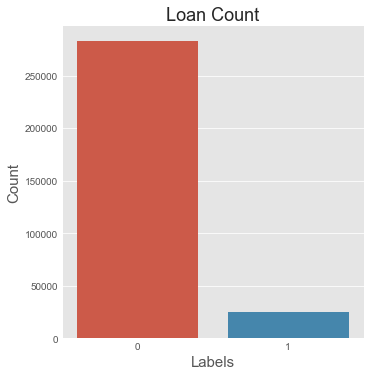

In [53]:
print("Distribuição da variável - Good(0) e Bad(1): ")
print(train["TARGET"].value_counts())

sns.factorplot(x ="TARGET", kind='count', data=train, size=5)
plt.title("Loan Count", fontsize=18)
plt.xlabel("Labels", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

### Qtde por feature e porcentagem de inadimplentes 

In [95]:
def plot_stats(data, feature,label_rotation=False,horizontal_layout=True):
    temp = data[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    #sns.set_style('whitegrid')
    
    # Calculate the percentage of target=1 per category value
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

  NAME_CONTRACT_TYPE    TARGET
0         Cash loans  0.083459
1    Revolving loans  0.054783


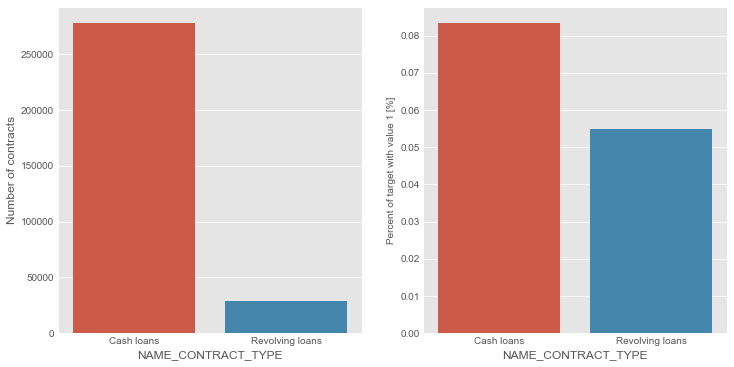

In [94]:
plot_stats(train, 'NAME_CONTRACT_TYPE')

In [119]:
# Distribuição de inadimplencia de acordo com a feature passada como parametro

def description_distribution(data, feature, by='TARGET'):
    return pd.crosstab(data[feature], train[by], margins=True)
    
print('Distribui')    
description_distribution(train, 'CODE_GENDER')

Distribui


TARGET,0,1,All
CODE_GENDER,,,
F,188278,14170,202448
M,94404,10655,105059
XNA,4,0,4
All,282686,24825,307511


In [96]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(data, var,nrow=2):
    
    i = 0
    t1 = data.loc[data['TARGET'] != 0]
    t0 = data.loc[data['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning:

invalid value encountered in less



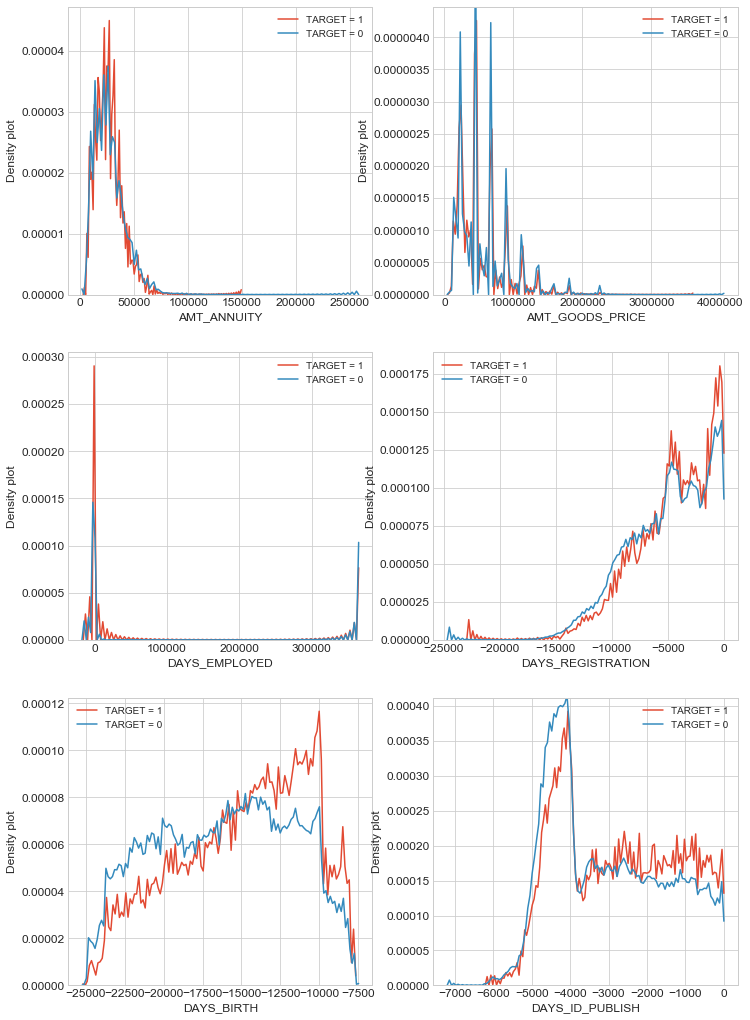

In [97]:
var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
plot_distribution_comp(train, var,nrow=3)

## Pearson Correlation of features

In [131]:
def plot_heatmap(dataset):
    data = [
        go.Heatmap(
            z= dataset.corr().values,
            x=dataset.columns.values,
            y=dataset.columns.values,
            colorscale='Viridis',
            reversescale = False,
            text = True ,
            opacity = 1.0 )
    ]

    layout = go.Layout(
        title='Pearson Correlation of features',
        xaxis = dict(ticks='', nticks=36),
        yaxis = dict(ticks='' ),
        width = 900, height = 700,
    margin=dict(
        l=240,
    ),)

    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='labelled-heatmap')

plot_heatmap(train)

In [148]:
def plot_sns_heatmap():
    colormap = plt.cm.Greens
    plt.figure(figsize=(14,12))

    sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, 
                 cmap = colormap, linecolor='white'
               #, square=True, annot=True
               )
    return plt.show()
    
#plot_sns_heatmap()

## Feature Importance using Random forest

In [133]:
categorical_feats = [f for f in train.columns if train[f].dtype == 'object']

for col in categorical_feats:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lb.transform(list(train[col].values.astype('str')))
    test[col] = lb.transform(list(test[col].values.astype('str')))
    
train.fillna(-999, inplace = True)

rf = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=4, max_features=0.5, random_state=2018)
rf.fit(train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET)
features = train.drop(['SK_ID_CURR', 'TARGET'],axis=1).columns.values



In [140]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    margin=dict(
    l=300,
),
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

## RASCUNHO

In [30]:
temp = train["ORGANIZATION_TYPE"].value_counts()
temp.iplot(kind='bar', xTitle = 'Organization Name', yTitle = "Count", 
           title = 'Types of Organizations who applied for loan ', color = 'red')

In [32]:
# Criando o data set por Tipo de Organização

def create_score_organization_type():

    temp = pd.DataFrame(train.groupby(['ORGANIZATION_TYPE', 'TARGET']).size())
    temp.reset_index(inplace=True)
    temp.rename(columns = {0:'Qtde'}, inplace = True)

    score_organization = pd.pivot_table(temp,index=['ORGANIZATION_TYPE'], columns=['TARGET'], 
                                        values=['Qtde'], aggfunc=[np.sum], fill_value=0, margins=True)
    score_organization.reset_index(inplace=True)
    score_organization.rename(columns={ 0:'good_credit', 1:'bad_credit'}, inplace=True)
    score_organization = score_organization.sort_values(by=[('sum', 'Qtde', 'All')], ascending=False)[1:len(score_organization)]

    return score_organization

score_organization = create_score_organization_type()


In [33]:
trace1 = go.Bar(
    x = score_organization['ORGANIZATION_TYPE'],
    y = score_organization[('sum', 'Qtde', 'good_credit')],
    name = 'Good'
)
trace2 = go.Bar(
    x = score_organization['ORGANIZATION_TYPE'],
    y = score_organization[('sum', 'Qtde', 'bad_credit')],
    name = 'Bad'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack', 
    title='Contratos por Tipo de Organização'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [34]:
temp = train["OCCUPATION_TYPE"].value_counts()
temp.iplot(kind='bar', xTitle = 'Occupation', yTitle = "Count", title = 'Occupation of Applicant\'s who applied for loan', color = 'green')